<a href="https://colab.research.google.com/github/sirawann/AppSnake/blob/master/Snake_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download modules

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import keras
import tensorflow as tf
from PIL import Image, ImageOps
%matplotlib inline

In [ ]:
''' !wget https://bitbucket.org/gnotsfw/snake/raw/0c0a5df03a4f6b2d086b443d21202c34edb9194c/images.zip '''

' !wget https://bitbucket.org/gnotsfw/snake/raw/0c0a5df03a4f6b2d086b443d21202c34edb9194c/images.zip '

In [ ]:
!wget https://bitbucket.org/gnotsfw/tong/raw/d831f5fb831004325b8dbc99b6870ec56dff7139/datasnake.zip

--2023-06-03 06:50:25--  https://bitbucket.org/gnotsfw/tong/raw/d831f5fb831004325b8dbc99b6870ec56dff7139/datasnake.zip
Resolving bitbucket.org (bitbucket.org)... 18.205.93.0, 18.205.93.1, 18.205.93.2, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1029816995 (982M) [application/zip]
Saving to: ‘datasnake.zip’

datasnake.zip       100%[===================>] 982.11M   146MB/s    in 8.2s    

2023-06-03 06:50:55 (120 MB/s) - ‘datasnake.zip’ saved [1029816995/1029816995]



In [ ]:
!unzip --qq datasnake.zip

In [ ]:
image_size = 224
batch_size = 32

In [ ]:

train_dir = '/content/train'
test_dir = '/content/val'
testing_dir = '/content/test'
input_shape = (image_size, image_size, 3)

Create image data generator for train data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = True,
                              height_shift_range= 0.05,
                              width_shift_range=0.2,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0)

Check generator

In [ ]:
import keras.utils as image
img_path = '/content/train/Mapao/mapao_1.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

Setting train generator

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 2729 images belonging to 7 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 245 images belonging to 7 classes.


Setting tesing generator without data augmentation

In [ ]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 210 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

In [ ]:
from keras.applications import MobileNet
pretrained_model = tf.keras.applications.MobileNetV2(weights="imagenet", input_shape=(image_size, image_size, 3), include_top=False)


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
pretrained_model.trainable = False
pretrained_model.summary()

In [ ]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(526)(x)
x = Activation('relu')(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filepath="mobilenetv2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2,
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=10,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 32
history = model.fit(
    train_generator,

    validation_data=test_generator,

    callbacks=callbacks_list,
    epochs=15,
    verbose=2)

Epoch 1/15

Epoch 1: val_loss improved from inf to 0.72722, saving model to mobilenetv2.h5
86/86 - 75s - loss: 0.6020 - accuracy: 0.7911 - val_loss: 0.7272 - val_accuracy: 0.7796 - lr: 0.0010 - 75s/epoch - 874ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.72722
86/86 - 61s - loss: 0.2448 - accuracy: 0.9135 - val_loss: 0.7360 - val_accuracy: 0.7837 - lr: 0.0010 - 61s/epoch - 708ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.72722 to 0.69739, saving model to mobilenetv2.h5
86/86 - 64s - loss: 0.1621 - accuracy: 0.9465 - val_loss: 0.6974 - val_accuracy: 0.8163 - lr: 0.0010 - 64s/epoch - 739ms/step
Epoch 4/15

Epoch 4: val_loss improved from 0.69739 to 0.45861, saving model to mobilenetv2.h5
86/86 - 62s - loss: 0.1300 - accuracy: 0.9527 - val_loss: 0.4586 - val_accuracy: 0.8694 - lr: 0.0010 - 62s/epoch - 719ms/step
Epoch 5/15

Epoch 5: val_loss did not improve from 0.45861
86/86 - 61s - loss: 0.1410 - accuracy: 0.9513 - val_loss: 0.5056 - val_accuracy: 0.8571 - lr: 0.0

In [ ]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-19-988243f5b692>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = model.evaluate_generator(testing_generator, batch_size)


[INFO] accuracy: 81.90%
[INFO] Loss:  0.6243096590042114


In [ ]:
train_score = model.evaluate_generator(train_generator, batch_size)

print("Train accuracy: {:.2f}%".format(train_score[1] * 100))

<ipython-input-20-4b5641dba7d0>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_score = model.evaluate_generator(train_generator, batch_size)


Train accuracy: 99.71%


confusion matrix format

<ipython-input-22-afd495c66ad9>:47: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testing_generator)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

        Aang       0.68      0.93      0.79        30
        Haow       0.73      0.73      0.73        30
        Laam       0.87      0.90      0.89        30
       Leuam       0.74      0.93      0.82        30
       Mapao       0.92      0.73      0.81        30
        Sing       0.96      0.73      0.83        30
       Thong       1.00      0.77      0.87        30

    accuracy                           0.82       210
   macro avg       0.84      0.82      0.82       210
weighted avg       0.84      0.82      0.82       210



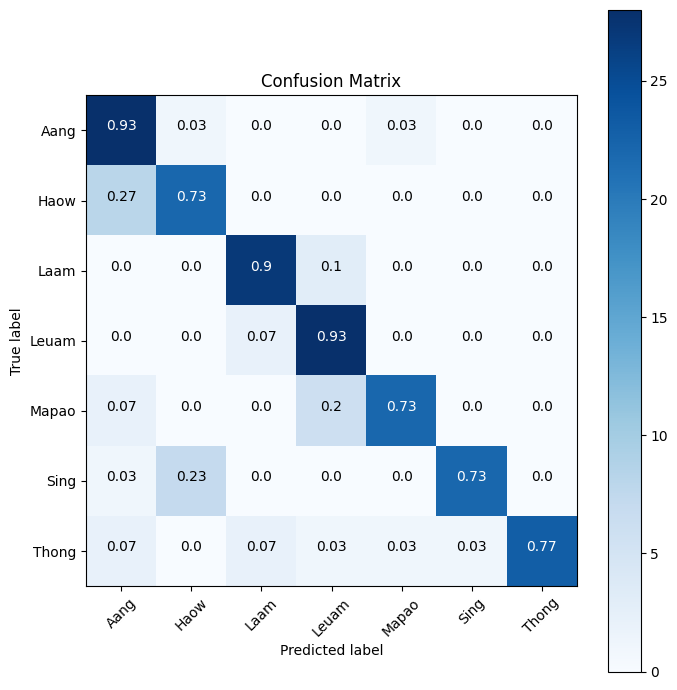

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix

Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))